In [10]:
# Importing all necessary libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Rescaling, SeparableConv2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
 
img_width, img_height = 180, 180

In [17]:
train_data_dir = r'C:\Users\smonn\Desktop\T8-AI&BigData_pdf\chest_Xray_3_class\train'
validation_data_dir = r'C:\Users\smonn\Desktop\T8-AI&BigData_pdf\chest_Xray_3_class\test'
nb_train_samples =5200
nb_validation_samples = 620
epochs = 100
batch_size = 35

In [3]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [4]:
model = Sequential()
model.add(Rescaling(1.0 / 255))
model.add(Conv2D(16, 3, activation="relu", padding="same", input_shape=input_shape))
model.add(Conv2D(16, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
 
model.add(SeparableConv2D(32, 3, activation="relu", padding="same"))
model.add(SeparableConv2D(32, 3, activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D())
 
model.add(SeparableConv2D(64, 3, activation="relu", padding="same"))
model.add(SeparableConv2D(64, 3, activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(SeparableConv2D(128, 3, activation="relu", padding="same"))
model.add(SeparableConv2D(128, 3, activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Dropout(0.2))
 
model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(3, activation="softmax"))

In [5]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

METRICS = [
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=METRICS)

model.build((None, img_width, img_height, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 90, 90, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 90, 90, 32)       1

In [6]:
import scipy
    
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
 
test_datagen = ImageDataGenerator(rescale=1. / 255)
 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')
 
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')
 
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb])

Found 5208 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Epoch 1/100
148/148 [==============================] - 73s 448ms/step - loss: 1.3880 - categorical_accuracy: 0.3719 - precision: 0.3829 - recall: 0.2815 - val_loss: 1.1333 - val_categorical_accuracy: 0.3866 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
148/148 [==============================] - 60s 403ms/step - loss: 0.9737 - categorical_accuracy: 0.5612 - precision: 0.6125 - recall: 0.4556 - val_loss: 1.4027 - val_categorical_accuracy: 0.3882 - val_precision: 0.3882 - val_recall: 0.3882
Epoch 3/100
148/148 [==============================] - 59s 398ms/step - loss: 0.8024 - categorical_accuracy: 0.6509 - precision: 0.6857 - recall: 0.5850 - val_loss: 1.4989 - val_categorical_accuracy: 0.3832 - val_precision: 0.3832 - val_recall: 0.3832
Epoch 4/100
148/148 [==============================] - 60s 401ms/step - loss: 0.7608 - categorical_accuracy: 0.6712 - precision: 0.7090 - recall: 0.6082 

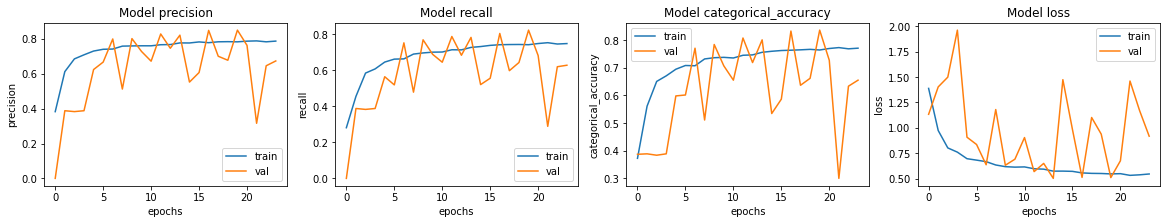

In [7]:
 fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "categorical_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [8]:
score = model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

18/18 [==============================] - 4s 232ms/step - loss: 0.5086 - categorical_accuracy: 0.8013 - precision: 0.8205 - recall: 0.7837
Test loss: 0.5086100101470947
Test accuracy: 0.8012820482254028


In [16]:
pred= model.predict(validation_generator, nb_validation_samples // batch_size)
predicted_class_indices=np.argmax(pred,axis=1)
labels=(validation_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)

[0 2 0 1 0 0 1 1 1 1 1 0 2 1 0 0 0 2 0 2 1 0 0 1 0 0 1 1 0 0 0 2 2 1 1 2 2
 2 0 1 1 0 2 0 2 1 1 0 0 0 2 2 1 0 1 1 0 1 2 0 1 0 1 0 0 1 1 0 1 1 1 1 2 1
 1 0 0 0 2 1 1 0 1 0 2 0 2 0 0 2 0 1 2 2 1 1 2 0 0 0 1 0 2 0 0 0 1 2 2 0 1
 0 0 0 0 1 2 1 1 0 2 0 2 1 1 1 1 0 0 2 0 2 1 0 1 0 1 1 1 1 1 2 1 2 1 0 1 1
 0 2 0 0 0 2 1 1 1 1 2 0 0 1 2 2 0 2 2 2 0 0 0 1 0 0 0 1 0 1 1 1 2 1 1 1 0
 0 1 2 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 2 0 0 1 0 0 0 2 1 0 1 2 1 0 0 2
 1 0 1 0 1 2 0 1 2 2 2 2 1 2 2 2 1 0 0 2 0 1 1 2 0 0 2 2 1 2 2 1 1 2 1 1 0
 0 0 2 0 2 0 1 0 1 1 2 2 0 0 2 0 0 0 2 2 1 2 2 0 1 2 1 1 1 2 1 1 1 0 1 2 0
 0 1 0 1 1 0 0 2 1 1 0 0 0 0 1 0 1 0 0 2 1 1 2 2 1 1 1 0 2 1 1 0 1 0 2 1 1
 0 1 2 2 2 1 1 0 1 0 2 0 1 2 2 1 1 2 2 1 1 0 2 0 1 0 1 2 1 0 1 2 0 0 1 1 0
 0 0 2 1 1 2 1 1 0 0 0 2 1 2 0 1 1 0 0 0 1 2 0 0 2 2 2 0 0 0 1 0 2 0 2 0 1
 0 1 0 1 0 2 0 1 0 1 0 1 0 0 0 1 2 0 0 2 0 1 2 1 1 1 1 2 0 0 0 0 2 2 1 1 0
 2 2 0 2 2 0 0 1 1 2 1 2 2 2 2 1 1 2 0 0 1 1 1 2 1 0 0 2 0 2 0 1 0 0 0 1 0
 1 0 0 2 2 2 1 1 0 0 0 2 

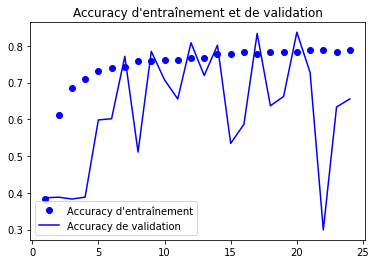

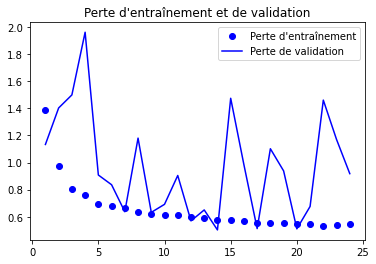

In [14]:
acc = history.history['precision']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label="Accuracy d'entraînement")
plt.plot(epochs, val_acc, 'b', label='Accuracy de validation')
plt.title("Accuracy d'entraînement et de validation")
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label="Perte d'entraînement")
plt.plot(epochs, val_loss, 'b', label='Perte de validation')
plt.title("Perte d'entraînement et de validation")
plt.legend()

(1, 180, 180, 3)


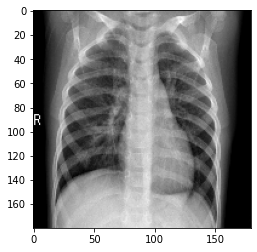

In [26]:
from keras.preprocessing import image

img_path = r"C:\Users\smonn\Desktop\T8-AI&BigData_pdf\val\PNEUMONIA_VIRUS\person86_virus_159.jpeg"
img = image.load_img(img_path, target_size=(180, 180))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
print(img_tensor.shape)

In [27]:
# Prédiction d'images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = np.argmax(model.predict(images, batch_size=10), axis=-1)
print("La classe prédite est :",classes)

La classe prédite est : [0]
